## Input packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter, defaultdict
from PIL import Image
import math
from pathlib import Path
from tqdm import tqdm

In [2]:
input_dir = "input\\"
print(os.listdir(input_dir))

['sample_submission.csv', 'test_images', 'train.csv', 'train_images']


file description¶
* train_images/ - folder of training images
* test_images/ - folder of test images (you are segmenting and classifying these images)
* train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
* sample_submission.csv - a sample submission file in the correct format; note, each ImageId 4 rows, one for each of the 4 defect classes

In [3]:
train_df = pd.read_csv(os.path.join(input_dir, "train.csv"))
sample_df = pd.read_csv(os.path.join(input_dir, "sample_submission.csv"))

In [4]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
sample_df.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


#### check the number of each classes

In [6]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col: col+4, 0].values]
    # 确保取出的是同一张图片的数据
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
    
    # 取出一张图片对应的4个类别, type = <class 'pandas.core.series.Series'>
    labels = train_df.iloc[col: col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
        
    # i.e. labels.isna().values = [False  True  True  True]
    kind_class_dict[sum(labels.isna().values == False)] += 1
    # 统计有无缺陷图片的个数，defaultdict(<class 'int'>, {1: 1, 0: 1})
    
    # print(labels.isna().values.tolist())  [False, True, True, True]
    for idx, label in enumerate(labels.isna().values.tolist()):
#         print(idx, label)
#          - 0 False
#          - 1 True
#          - 2 True
#          - 3 True
        if label == False:
            # 统计每个缺陷类别的图片个数
            class_dict[idx + 1] += 1
            # print(class_dict)  defaultdict(<class 'int'>, {1: 14, 3: 37, 4: 10, 2: 4})

In [7]:
no_defects_num, defects_num

(5902, 6666)

defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

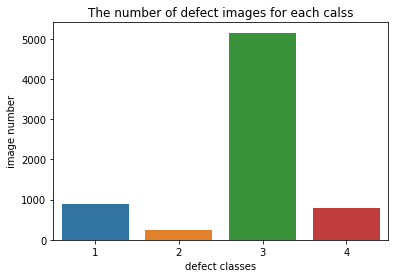

In [8]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("The number of defect images for each calss")
ax.set_xlabel("defect classes")
ax.set_ylabel("image number")
class_dict

* There are similar numbers of images with and without defects.
* class is imbalanced

defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

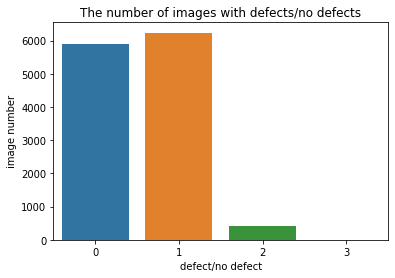

In [9]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_xlabel("defect/no defect")
ax.set_ylabel("image number")
ax.set_title("The number of images with defects/no defects")
kind_class_dict

almost image have no defect or one kind of defects

## Check image data

In [10]:
train_size_dict = defaultdict(int)
train_path = Path("input\\train_images\\")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [11]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [12]:
test_size_dict = defaultdict(int)
test_path = Path("input\\test_images\\")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

In [13]:
test_size_dict

defaultdict(int, {(1600, 256): 1801})

## Visualize masks

In [14]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249, 50, 12)]

In [15]:
def get_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col: col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col: col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)
    
    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            # reshape的order参数解析：https://www.jianshu.com/p/fc2fe026f002
            # order : 可选范围为{‘C’, ‘F’, ‘A’}。使用索引顺序读取a的元素，并按照索引顺序将元素放到变换后的的数组中。如果不进行order参数的设置
            # 默认参数为C。
            # - “C”指的是用类C写的读/索引顺序的元素，最后一个维度变化最快，第一个维度变化最慢。以二维数组为例，简单来讲就是横着读，横着写，优先读/写一行。
            # - “F”是指用FORTRAN类索引顺序读/写元素，最后一个维度变化最慢，第一个维度变化最快。竖着读，竖着写，优先读/写一列。注意，“C”和“F”选项不考虑底层数组的内存布局，只引用索引的顺序。
            # - “A”选项所生成的数组的效果与原数组a的数据存储方式有关，如果数据是按照FORTRAN存储的话，它的生成效果与”F“相同，否则与“C”相同。
            mask[:, :, idx] = mask_label.reshape(256, 1600, order="F")
        
    return img_names[0], mask

In [16]:
def show_mask_image(col):
    name, mask = get_mask(col)
    img = cv2.imread(os.path.join(train_path, name))
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    for ch in range(4):
        # https://blog.csdn.net/sunny2038/article/details/12889059
        # cv2.findContours(image, mode, method[, contours[, hierarchy[, offset ]]])
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

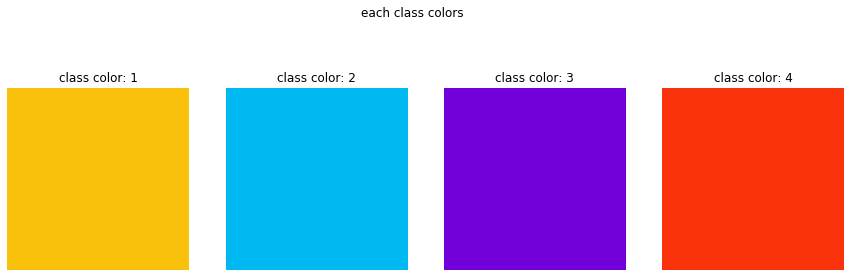

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    ax[i].axis("off")
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title(f"class color: {i+1}")
fig.suptitle("each class colors")

plt.show()

In [18]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_double = []
idx_class_triple = []
idx_class_quattuor = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col: col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col: col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 0:
        idx_class_quattuor.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_double.append(col)

#### images with no defect

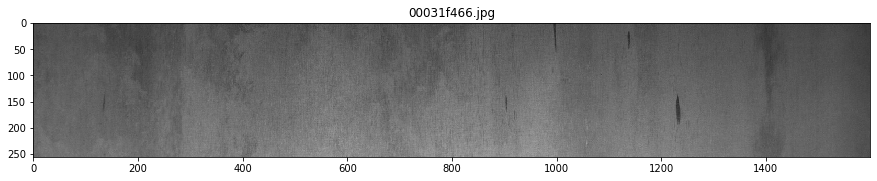

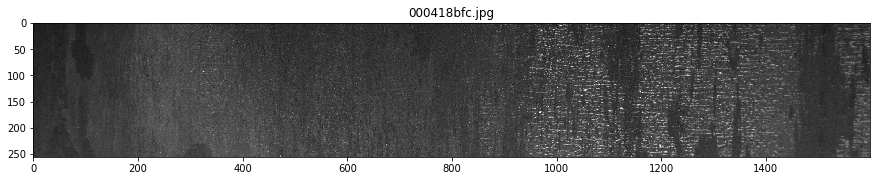

In [19]:
for idx in idx_no_defect[:2]:
    show_mask_image(idx)

#### images with defect -- label: 1

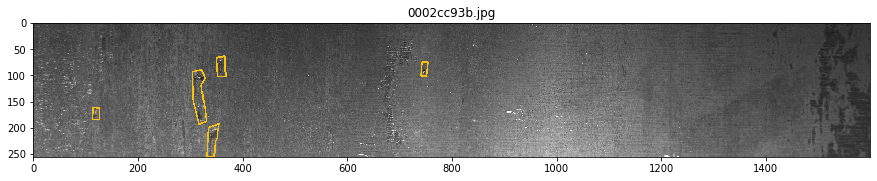

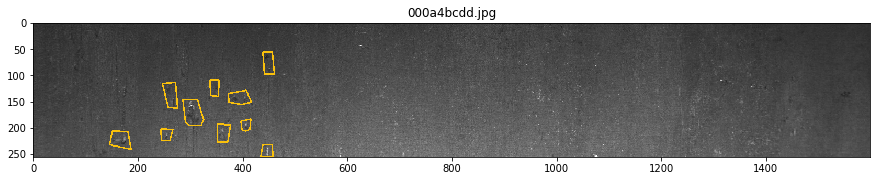

In [20]:
for idx in idx_class_1[:2]:
    show_mask_image(idx)

#### images with defect -- label: 2

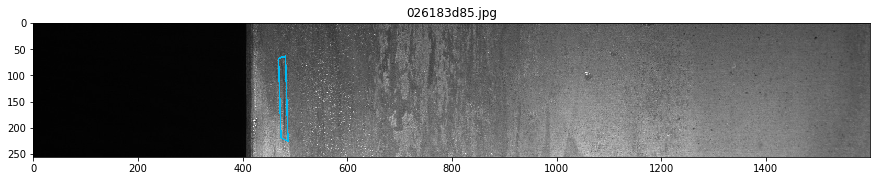

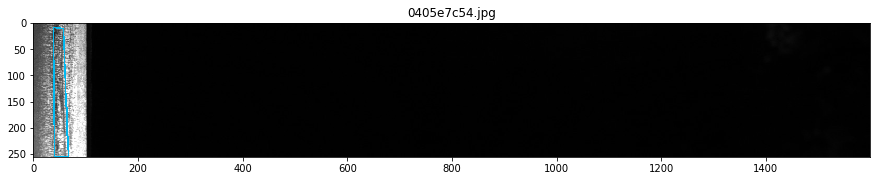

In [21]:
for idx in idx_class_2[:2]:
    show_mask_image(idx)

#### images with defect -- label: 3

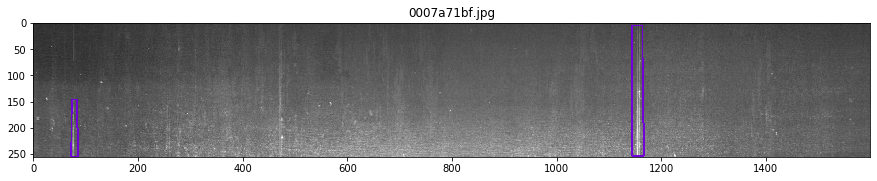

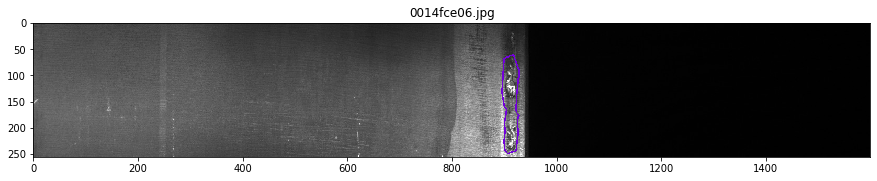

In [25]:
for idx in idx_class_3[:2]:
    show_mask_image(idx)

#### images with defect -- label: 4

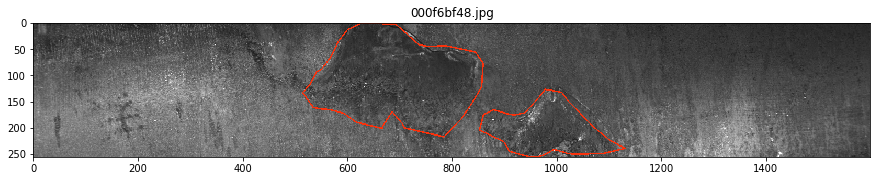

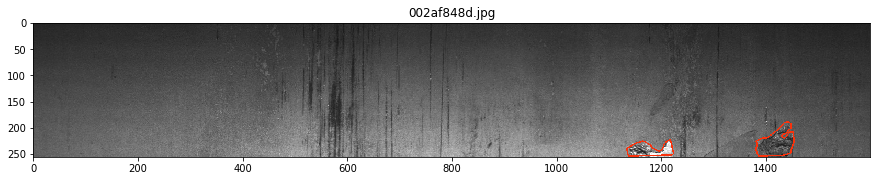

In [23]:
for idx in idx_class_4[:2]:
    show_mask_image(idx)

#### images with defect -- double

In [24]:
len(idx_class_double), len(idx_class_triple), len(idx_class_quattuor)

(425, 2, 0)

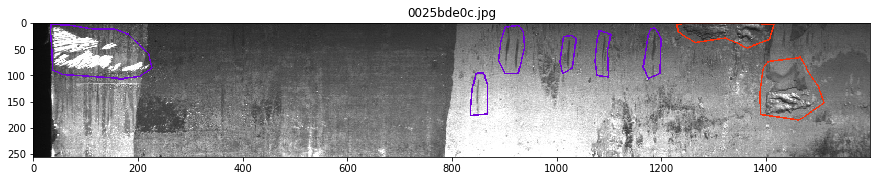

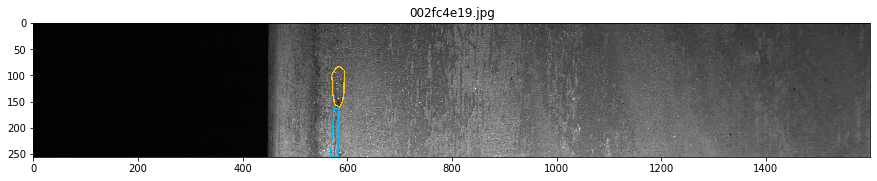

In [26]:
for idx in idx_class_double[:2]:
    show_mask_image(idx)

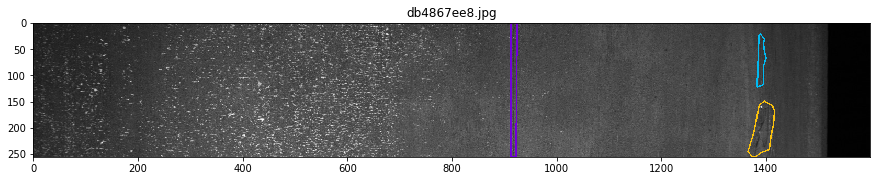

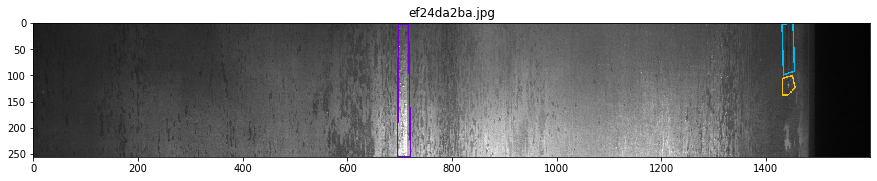

In [28]:
for idx in idx_class_triple:
    show_mask_image(idx)

## Is there the pixel that have multi label?

In [36]:
for col in tqdm(range(0, len(train_df), 4)):
    name, mask = get_mask(col)
    if (mask.sum(axis=2) >= 2).any():
        show_mask_image(col)

100%|████████████████████████████████████████████████████████████████████████████| 12568/12568 [02:41<00:00, 77.73it/s]


* all pixels have one or less label